### Pair Trading Strategy Between General Motors and Ford Motor Company

We have a pair of securities/stock prices for General Motors and Ford Motor Company - that have an underlying economic link - two big automakers in the United States. It is expected that the difference in prices(spread) reamins constant over a period of time. 

##### Slight divergences may exist but these divergences are expected to revert back to normal with time, enabling us to make the pairs trade

#### How it works:
When there is a temporary divergence, the trade sells the outperforming stock and buys the underperforming stock, thereby making a bet that the stread eventually converges by either one of them moving back to the original or both of them moving back. If both stocks move with each other, then we neither make nor lose any money

In [2]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#below package to perform linear regression
import statsmodels.api as sm


In [18]:
df1 = pd.read_csv('GeneralMotorsData.csv')
df2 = pd.read_csv('FordMotorCompanyData.csv')

Note: Financial Data from February 7th 2020 to February 7th 2021 is split into training and testing sets and analysis is performed

In [19]:
#removing the first row to have matching information in both dataframes before merge
df1 = df1.tail(-1)

In [21]:
mainDF = pd.merge(df1,df2, on='Date', suffixes=('-GMC','-FMC'))


In [28]:
mainDF.set_index('Date', inplace=True)

In [43]:
#training set - 75% of the information, test set - 25% of the information
import math
trainingSet = np.arange(0,math.floor((75./100)*mainDF.shape[0]))
testSet = np.arange(trainingSet.shape[0],mainDF.shape[0])

In [51]:
#Determining the hedge ratio from the OLS
x = mainDF.loc[:, 'Adj Close-GMC'].iloc[trainingSet]
y = mainDF.loc[:,'Adj Close-FMC'].iloc[trainingSet]

In [54]:
modelResults = sm.OLS(x,y).fit()

In [58]:
modelResults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Adj Close-GMC   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                          1.027e+04
Date:                Wed, 08 Feb 2023   Prob (F-statistic):                        0.00
Time:                        16:22:14   Log-Likelihood:                         -2129.3
No. Observations:                 565   AIC:                                      4261.
Df Residuals:                     564   BIC:                                      4265.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Adj Close-FMC     3.6091      0.036    101.338      0.000       3.539       3.679
==============================================================================
Omnibus:                       63.705   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.479
Skew:                          -0.946   Prob(JB):                     4.53e-19
Kurtosis:                       2.912   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### The Hedge Ratio is telling us the value of the position protected through the use of a hedge with the size of the entire position itself

In [64]:
hedgeRatio = modelResults.params
hedgeRatio

Adj Close-FMC    3.609141
dtype: float64

Now time to define the entry and exit thresholds of the portfolio and look at the performance on the testing set

In [117]:
mainDF.index = pd.to_datetime(mainDF.index,format = '%Y-%m-%d %H:%M')

In [118]:
spread = mainDF.loc[:,'Adj Close-GMC']-hedgeRatio[0]*mainDF.loc[:,'Adj Close-FMC']

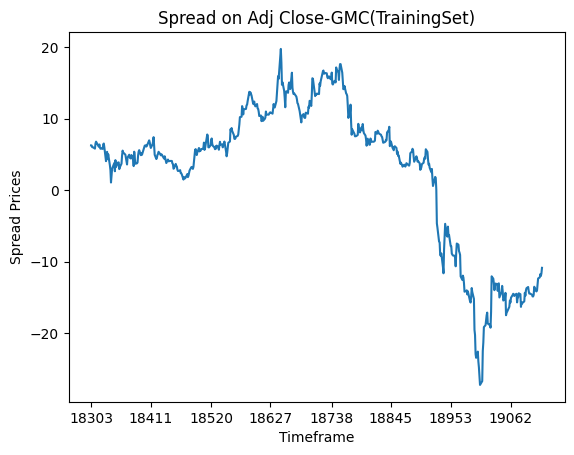

In [124]:
#How the plots of the spread look for the training set and the test sets
plt.figure()
plt.title("Spread on Adj Close-GMC(TrainingSet)")
plt.ylabel("Spread Prices")
plt.xlabel("Timeframe")
ticks = list (mainDF.index)
plt.xticks([ticks[i] for i in range(trainingSet.shape[0]) if i%75 == 0])
plt.plot(spread.iloc[trainingSet])

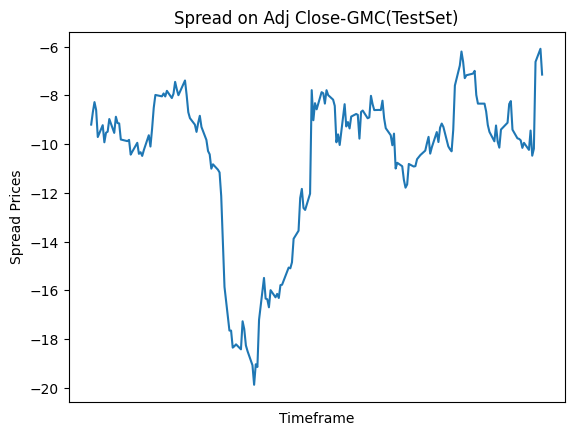

In [220]:
plt.figure()
plt.title("Spread on Adj Close-GMC(TestSet)")
plt.ylabel("Spread Prices")
plt.xlabel("Timeframe")
ticks = list (mainDF.index)
plt.xticks([ticks[i] for i in range(testSet.shape[0]) if i%75 == 0])
plt.plot(spread.iloc[testSet])

In [221]:
spreadMean = np.mean(spread.iloc[trainingSet])
spreadStd = np.std(spread.iloc[trainingSet])

The z-scores = (spread value - spread mean)/spread Standard Deviation

In [264]:
mainDF['z-score'] = (spread - spreadMean)/spreadStd
mainDF['z-score']

Date
2020-02-11    0.350980
2020-02-12    0.349520
2020-02-13    0.326659
2020-02-14    0.326697
2020-02-18    0.306440
                ...   
2023-02-01   -1.301610
2023-02-02   -1.273251
2023-02-03   -0.921277
2023-02-06   -0.868459
2023-02-07   -0.973028
Name: z-score, Length: 754, dtype: float64

In [223]:
#naming columns for long and short positions for both GMC and FMC
mainDF['Positions-GMC-Long'] = mainDF['Positions-GMC-Short'] = mainDF['Positions-FMC-Short'] =  mainDF['Positions-FMC-Long'] = 0

#### General Probability Theory:
- For positions with the zscore >=1.25 or <=-1.25 short and long positions on FMC and GMC
- For positions with zscore >=0.25 or <=-0.25 perform the opposite and close the position



In [276]:
mainDF.loc[mainDF['z-score'] >= 1.25,('Positions-GMC-Short','Positions-FMC-Short')]=[-1,1]
mainDF.loc[mainDF['z-score'] <= -1.25, ('Positions-GMC-Long','Positions-FMC-Long')]=[1,-1]


In [277]:
mainDF.loc[mainDF['z-score'] >= -0.25, ('Positions-GMC-Long', 'Positions-FMC-Long')] = [0,0]
mainDF.loc[mainDF['z-score'] <= 0.25, ('Positions-GMC-Short', 'Positions-FMC-Short')] = [0,0]

In [278]:
longPositions = mainDF.loc[:,('Positions-GMC-Long','Positions-FMC-Long')]
shortPositions = mainDF.loc[:,('Positions-GMC-Short','Positions-FMC-Short')]

In [279]:
totalPositions = np.array(longPositions) + np.array(shortPositions)
totalPositions = pd.DataFrame(totalPositions)


In [280]:
#Calculating the daily returns on the original Adj Close Returns
dailyReturns = mainDF.loc[:,('Adj Close-GMC', 'Adj Close-FMC')].pct_change()
dailyReturns

,Adj Close-GMC,Adj Close-FMC
Date,,
2020-02-11,NaN,NaN
2020-02-12,0.013710,0.017284
2020-02-13,-0.005635,0.001214
2020-02-14,-0.015018,-0.018182
2020-02-18,-0.010069,-0.004938
...,...,...
2023-02-01,-0.000509,0.020725
2023-02-02,0.055980,0.038434
2023-02-03,-0.008916,-0.076117


In [281]:
#since the first row of dailyReturns does not have any values
comparisonReturns = (np.array(totalPositions.shift())*np.array(dailyReturns)).sum(axis = 1)


In [282]:
sharpeTestRatio = np.sqrt(252)*np.mean(comparisonReturns[testSet[1:]])/np.std(comparisonReturns[testSet[1:]])

In [289]:
sharpeTestRatio


2.3046087414201817

Optimizing the parameters for the entry and exit thresholds results in a Sharpe Ratio for the test set of more tha 2.3
-Due to the nature of the financial data retrieved from Yahoo, there appears to be survivorship bias in the background.
There is a possibility of data snooping bias if the parameters are optimized in such a way so as to improve the testing set rather than the training set.
Similar positions can be used for the pair trading strategy including but not limited to:
- Gold and Silver
- Coke and Pepsi
-S&P 500 and Nasdaq 100